## 中国建模

In [1]:
import numpy as np 
import pandas as pd 
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from torch import nn
from torch.autograd import Variable

设置随机数种子

In [2]:
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(666)

数据处理

In [3]:
covid=pd.read_csv('worldometer_coronavirus_daily_data.csv')
covid['date'] = pd.to_datetime(covid['date'])
china = covid[covid['country']=='China'].loc[:, ['date', 'daily_new_cases']]

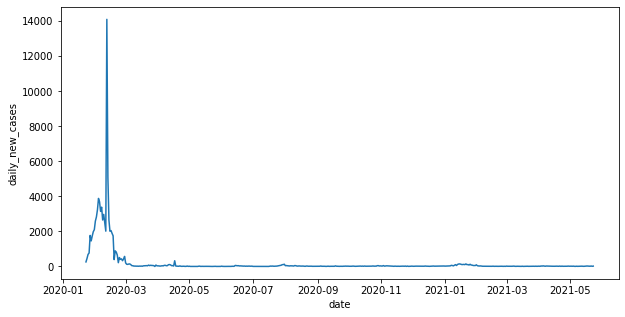

In [4]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=china, x='date', y='daily_new_cases')
plt.show()

In [5]:
china = china[china['date']>pd.to_datetime('20200501')]

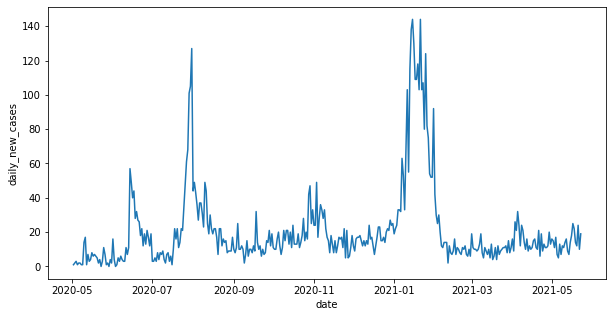

In [6]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=china, x='date', y='daily_new_cases')
plt.show()

In [7]:
base_day = 30
test_day = 60

In [8]:
dataset = china.loc[:,['daily_new_cases']].values.astype(np.float32)

In [9]:
train = dataset[:-test_day]
test = dataset[-test_day:]

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train.reshape(-1, 1))

In [11]:
def create_dataset(data):
    dataX, dataY = [], []
    for i in range(len(data) - base_day):
        a = data[i:(i + base_day)]
        dataX.append(a)
        dataY.append(data[i+base_day])
    dataX = np.array(dataX).reshape(-1, 1, base_day)
    dataY = np.array(dataY).reshape(-1, 1, 1)
    return dataX, dataY

In [12]:
train_X, train_Y = create_dataset(train_norm)

In [13]:
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)

建模

In [14]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.05)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [15]:
net = lstm_reg(base_day, 100)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [16]:
for e in range(2000):
    out = net(train_x)
    loss = criterion(out, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.10f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.0387945659
Epoch: 200, Loss: 0.0248092152
Epoch: 300, Loss: 0.0158615727
Epoch: 400, Loss: 0.0104215695
Epoch: 500, Loss: 0.0098548057
Epoch: 600, Loss: 0.0065987548
Epoch: 700, Loss: 0.0059324200
Epoch: 800, Loss: 0.0060575316
Epoch: 900, Loss: 0.0051588723
Epoch: 1000, Loss: 0.0043904316
Epoch: 1100, Loss: 0.0051121097
Epoch: 1200, Loss: 0.0045024497
Epoch: 1300, Loss: 0.0041935411
Epoch: 1400, Loss: 0.0035071140
Epoch: 1500, Loss: 0.0033431021
Epoch: 1600, Loss: 0.0033158986
Epoch: 1700, Loss: 0.0035153639
Epoch: 1800, Loss: 0.0032249216
Epoch: 1900, Loss: 0.0028109008
Epoch: 2000, Loss: 0.0026310089


In [17]:
net = net.eval()

In [18]:
test_x = [list(train_norm[-base_day:,0])]
pred = []

In [19]:
for i in range(test_day):
    seq = torch.from_numpy((np.array(test_x).astype('float32').reshape(-1, 1, base_day)))
    p = net(seq).data.numpy()[-1, -1, -1]
    pred.append(p)
    test_x.append(test_x[-1][1:]+[p])

In [20]:
pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))

In [21]:
print('L1Loss:', criterion(torch.from_numpy(pred), torch.from_numpy(test)).item())

L1Loss: 6.231405735015869


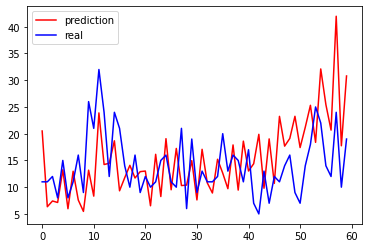

In [22]:
plt.plot(pred, 'r', label='prediction')
plt.plot(test, 'b', label='real')
plt.legend(loc='best')
plt.show()

In [23]:
y = pred[:, 0].tolist()

In [24]:
x = range(train.shape[0]+1,train.shape[0]+test.shape[0]+1)

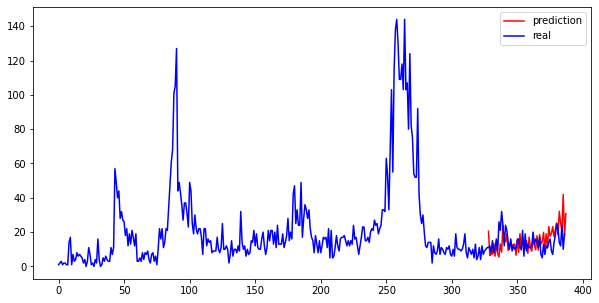

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(x,y, 'r', label='prediction')
plt.plot(np.append(train, test), 'b', label='real')
plt.legend(loc='best')

## 美国建模

In [26]:
usa = covid[covid['country']=='USA'].loc[:, ['date', 'daily_new_cases']].fillna(0)

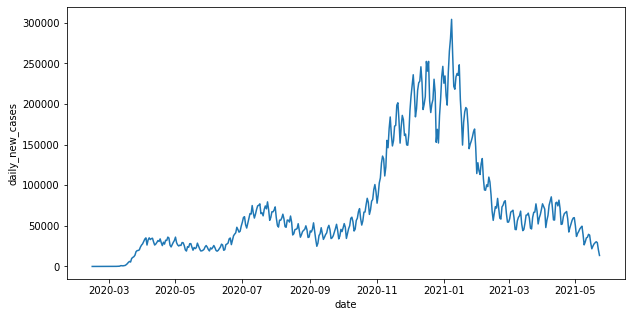

In [27]:
plt.figure(figsize=(10, 5))
sns.lineplot(data=usa, x='date', y='daily_new_cases')
plt.show()

In [28]:
base_day = 30
test_day = 60

In [29]:
dataset = usa.loc[:,['daily_new_cases']].values.astype(np.float32)

In [30]:
train = dataset[:-test_day]
test = dataset[-test_day:]

In [31]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_norm = scaler.fit_transform(train.reshape(-1, 1))

In [32]:
train_X, train_Y = create_dataset(train_norm)

In [33]:
train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)

建模

In [34]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=0.05)
        self.reg = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x, _ = self.rnn(x)
        s, b, h = x.shape
        x = x.view(s*b, h)
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [35]:
net = lstm_reg(base_day, 100)
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [36]:
for e in range(2000):
    out = net(train_x)
    loss = criterion(out, train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0:
        print('Epoch: {}, Loss: {:.10f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.0264248587
Epoch: 200, Loss: 0.0139696533
Epoch: 300, Loss: 0.0128347045
Epoch: 400, Loss: 0.0111832209
Epoch: 500, Loss: 0.0100993766
Epoch: 600, Loss: 0.0102937510
Epoch: 700, Loss: 0.0096987290
Epoch: 800, Loss: 0.0088652149
Epoch: 900, Loss: 0.0089947116
Epoch: 1000, Loss: 0.0066171424
Epoch: 1100, Loss: 0.0066685942
Epoch: 1200, Loss: 0.0060579153
Epoch: 1300, Loss: 0.0071359389
Epoch: 1400, Loss: 0.0063733817
Epoch: 1500, Loss: 0.0045855441
Epoch: 1600, Loss: 0.0048569748
Epoch: 1700, Loss: 0.0046436149
Epoch: 1800, Loss: 0.0046048979
Epoch: 1900, Loss: 0.0065178457
Epoch: 2000, Loss: 0.0045015328


In [37]:
net = net.eval()

In [38]:
test_x = [list(train_norm[-base_day:,0])]
pred = []

In [39]:
for i in range(test_day):
    seq = torch.from_numpy((np.array(test_x).astype('float32').reshape(-1, 1, base_day)))
    p = net(seq).data.numpy()[-1, -1, -1]
    pred.append(p)
    test_x.append(test_x[-1][1:]+[p])

In [40]:
pred = scaler.inverse_transform(np.array(pred).reshape(-1, 1))

In [41]:
print('L1Loss:', criterion(torch.from_numpy(pred), torch.from_numpy(test)).item())

L1Loss: 9574.85546875


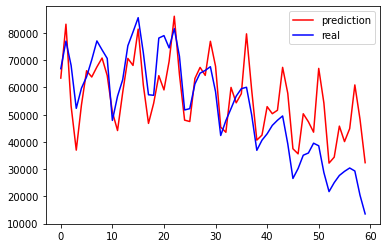

In [42]:
plt.plot(pred, 'r', label='prediction')
plt.plot(test, 'b', label='real')
plt.legend(loc='best')
plt.show()

In [43]:
y = pred[:, 0].tolist()

In [44]:
x = range(train.shape[0]+1,train.shape[0]+test.shape[0]+1)

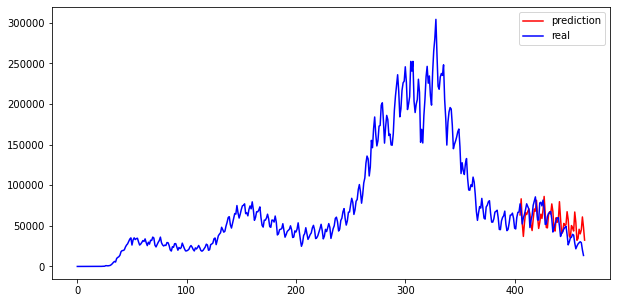

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(x,y, 'r', label='prediction')
plt.plot(np.append(train, test), 'b', label='real')
plt.legend(loc='best')